#### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
%matplotlib inline
import os
import warnings
import glob
warnings.filterwarnings('ignore')

from kmodes.kmodes import KModes

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

#### Data Load

In [2]:
# path = './data/'
# filenames = os.listdir('./data')
data_lst = []

path = os.path.abspath('data')
all_files = glob.glob(path + "\data_*.csv")

for file in all_files:
    var_name = file[41:-4]
    globals()[f'{var_name}'] = pd.read_csv(file, low_memory=False)
    globals()[f'{var_name}'].drop(['Self_conf'], axis=1, inplace=True)
    data_lst.append(globals()[f'{var_name}'])

In [3]:
data = data_08

In [4]:
def to_int(data):
    result = data.copy()
    result['Gender'] = np.where(result['Gender'] == '남성', 0, 1)
    result['Job']  = np.where(result['Job'] == '비경활', 0,
                    np.where(result['Job'].isin(['은퇴','부분은퇴']), 1,
                            np.where(result['Job'] == '임금_고숙련', 4,
                                np.where(result['Job'] == '임금_중숙련', 3,
                                    np.where(result['Job'] == '임금_저숙련', 2,
                                        np.where(result['Job'] == '자영업', 5, 6))))))
    result['Edu'] = np.where(result['Edu'] == '초등', 0,
                    np.where(result['Edu'] == '중등', 1,
                        np.where(result['Edu'] == '고등', 2, 3)))
    result['Health'] = np.where(result['Health'] == '활동에 제한 있음', 0,
                        np.where(result['Health'] == '그렇지 않은 편', 1, 2))
    result['Earn'] = np.where(result['Earn'] == '하', 0,
                    np.where(result['Earn'] == '중', 1, 2))
    # data['Self_conf'] = np.where(data['Self_conf'] == '하', 0,
    #                         np.where(data['Self_conf'] == '중', 1, 2))
    return result

## Clustering

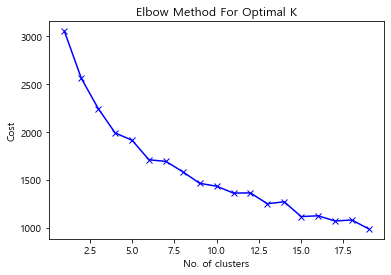

In [5]:
K = range(1, 20)
cost = []
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = 'random', random_state=2022)
    kmode.fit_predict(data.drop(['Gender'], axis=1))
    cost.append(kmode.cost_)

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal K')
plt.show()

#### Silhouette Score

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score
kmodes = KModes(n_clusters=6, init='random', random_state=2022)
kmodes.fit_predict(data.drop(['Gender'], axis=1))

array([2, 3, 0, ..., 4, 5, 4], dtype=uint16)

In [7]:
kmodes.labels_

array([2, 3, 0, ..., 4, 5, 4], dtype=uint16)

In [8]:
def visualize_silhouette(cluster_lists, X_features): 
    from kmodes.kmodes import KModes
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KModes(n_clusters = n_cluster, max_iter=500, random_state=2022)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

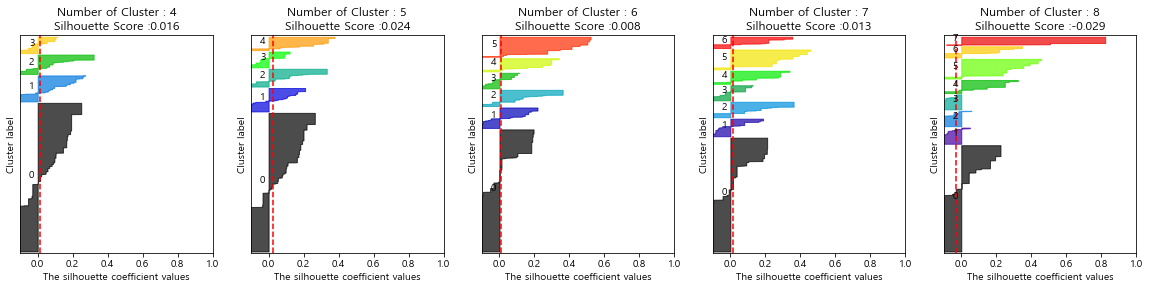

In [9]:
int_data = to_int(data)
visualize_silhouette([4,5,6,7,8], int_data.drop(['Gender'], axis=1))

In [10]:
kmode = KModes(n_clusters=6, init='random', random_state=2022)
kmode.fit_predict(data.drop(['Gender'], axis=1))
data['Cluster'] = kmode.labels_

#### Data Analysis

In [11]:
Static = data.drop(['Cluster'], axis=1)
Static.Gender.value_counts(normalize=True)

여성    0.5903
남성    0.4097
Name: Gender, dtype: float64

In [12]:
Male = Static[Static['Gender']=='남성']
Female = Static[Static['Gender']=='여성']

In [13]:
print('Total: \n', Static.Job.value_counts(normalize=True))
print('Male: \n',Male.Job.value_counts(normalize=True))
print('Female: \n', Female.Job.value_counts(normalize=True))

Total: 
 비경활        0.446075
임금_저숙련     0.278877
임금_중숙련     0.202297
임금_고숙련     0.060625
은퇴         0.010211
무급가족종사자    0.001276
자영업        0.000638
Name: Job, dtype: float64
Male: 
 임금_중숙련     0.338006
비경활        0.283489
임금_저숙련     0.253894
임금_고숙련     0.104361
은퇴         0.015576
무급가족종사자    0.003115
자영업        0.001558
Name: Job, dtype: float64
Female: 
 비경활       0.558919
임금_저숙련    0.296216
임금_중숙련    0.108108
임금_고숙련    0.030270
은퇴        0.006486
Name: Job, dtype: float64


In [14]:
print('Total: \n', Static.Edu.value_counts(normalize=True))
print('Male: \n',Male.Edu.value_counts(normalize=True))
print('Female: \n', Female.Edu.value_counts(normalize=True))

Total: 
 중등        0.496490
고등        0.185705
초등        0.166560
대학교 이상    0.151244
Name: Edu, dtype: float64
Male: 
 중등        0.501558
초등        0.260125
고등        0.143302
대학교 이상    0.095016
Name: Edu, dtype: float64
Female: 
 중등        0.492973
고등        0.215135
대학교 이상    0.190270
초등        0.101622
Name: Edu, dtype: float64


In [15]:
print('Total: \n', Static.Health.value_counts(normalize=True))
print('Male: \n',Male.Health.value_counts(normalize=True))
print('Female: \n', Female.Health.value_counts(normalize=True))

Total: 
 그렇지 않은 편     0.560944
전혀 지장 없음     0.234205
활동에 제한 있음    0.204850
Name: Health, dtype: float64
Male: 
 그렇지 않은 편     0.559190
전혀 지장 없음     0.261682
활동에 제한 있음    0.179128
Name: Health, dtype: float64
Female: 
 그렇지 않은 편     0.562162
활동에 제한 있음    0.222703
전혀 지장 없음     0.215135
Name: Health, dtype: float64


In [16]:
print('Total: \n', Static.Earn.value_counts(normalize=True))
print('Male: \n',Male.Earn.value_counts(normalize=True))
print('Female: \n', Female.Earn.value_counts(normalize=True))

Total: 
 상    0.547543
중    0.322272
하    0.130185
Name: Earn, dtype: float64
Male: 
 상    0.607477
중    0.291277
하    0.101246
Name: Earn, dtype: float64
Female: 
 상    0.505946
중    0.343784
하    0.150270
Name: Earn, dtype: float64


#### For Pre New Elder

In [17]:
pre = pd.read_csv('./data/Lt08.csv')
pre

,pid,hhid,HHID20,CID20,ed,w08wgt_c,w08wgt_p,w01,w02,w03,...,w08G014,w08G026,w08G027,w08G028,w08G029,w08G030,w08G031,w08G032,w08Ba001,w08Ba002
0,11,1,10000000,11,833,1600.303883,2189.837105,1,1.0,1.0,...,NaN,80,60,NaN,60.0,70,4,20,1.0,NaN
1,21,2,20000000,21,833,3180.749884,3919.849664,1,1.0,1.0,...,NaN,50,40,60.0,50.0,30,5,10,1.0,NaN
2,22,2,20000000,21,833,4525.161503,5994.598161,1,1.0,1.0,...,NaN,60,50,60.0,NaN,60,4,20,1.0,NaN
3,41,4,40000000,41,833,1239.297401,1695.840060,1,1.0,1.0,...,NaN,70,60,60.0,70.0,60,5,10,1.0,NaN
4,42,4,40000000,41,833,1069.049862,1207.745056,1,1.0,1.0,...,NaN,60,60,70.0,NaN,60,6,5,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712,61671,6167,61670000000,61671,672,1962.325562,2019.482662,1,1.0,1.0,...,NaN,30,30,NaN,80.0,50,5,5,1.0,NaN
5713,61681,6168,61680000000,61681,672,1439.828558,1481.766769,1,1.0,1.0,...,NaN,20,30,NaN,50.0,50,6,2,1.0,NaN
5714,61691,6169,61690000000,61691,672,1440.165656,1482.113687,1,1.0,1.0,...,NaN,50,50,NaN,80.0,50,5,2,1.0,NaN
5715,61701,6170,61700000000,61701,672,822.192069,1432.032181,1,1.0,1.0,...,NaN,50,50,NaN,80.0,80,4,5,1.0,NaN


In [18]:
def new_preprocessing(data, period):
    # data = data[(data[f'w{period}A002_age'] >= 60) & (data[f'w{period}A002_age'] < 65)]
    data['Earn_Score'] = data[f'w{period}hhinc'] / np.sqrt(data[f'w{period}hhsize'])

    data['Earn'] = pd.qcut(data['Earn_Score'], 3, labels=['하', '중', '상'])

    index = data[data.Earn.isna()==True].index
    data.drop(index, inplace=True)

    data = data[data[f'w{period}A002y'] < 1955]
    data['Gender'] = np.where(data[f'w{period}gender1'] == 1, '남성', '여성')
    
    data['Job'] = np.where(data[f'w{period}present_ecotype'] == 3, '비경활',
                           np.where(data[f'w{period}retired'].isin([1.0, 2.0]), '은퇴',
                                np.where(data[f'w{period}job'].isin([1.0, 2.0]), '임금_고숙련',
                                        np.where(data[f'w{period}job'].isin([3.0, 6.0, 7.0, 8.0, -9.0]), '임금_중숙련',
                                                np.where(data[f'w{period}job'].isin([4.0, 5.0, 9.0]), '임금_저숙련',
                                                        np.where(data[f'w{period}emp'] == 2.0, '자영업', '무급가족종사자'))))))
    data['Edu'] = np.where(data[f'w{period}edu'] == 1, '대학교 이상',
                           np.where(data[f'w{period}edu'] == 2, '고등',
                                   np.where(data[f'w{period}edu'] == 3, '중등', '초등')))
    data['Health'] = np.where(data[f'w{period}C005'].isin([1,2]), '활동에 제한 있음',
                              np.where(data[f'w{period}C005'] == 3,'그렇지 않은 편', '전혀 지장 없음'))
                              
    data['Self_conf_Score'] = data[f'w{period}G026'] + data[f'w{period}G027'] + data[f'w{period}G028'] + data[f'w{period}G029'] + data[f'w{period}G030']

    data['Self_conf'] = np.where(data['Self_conf_Score'] > 350, '상',
                                 np.where(data['Self_conf_Score'] < 200, '하', '중'))
    
    data = data[['Gender','Job', 'Edu', 'Health', 'Earn']]
    data.reset_index(drop=True, inplace=True)
    return data

In [19]:
pre = new_preprocessing(pre, '08')

In [20]:
print('직업지위: \n', pre.Job.value_counts(normalize=True))
print('학력수준: \n', pre.Edu.value_counts(normalize=True))
print('활동제한 수준: \n', pre.Health.value_counts(normalize=True))
print('소득: \n', pre.Earn.value_counts(normalize=True))

직업지위: 
 비경활        0.785126
임금_저숙련     0.104893
임금_중숙련     0.092054
임금_고숙련     0.015262
은퇴         0.002180
자영업        0.000242
무급가족종사자    0.000242
Name: Job, dtype: float64
학력수준: 
 대학교 이상    0.518653
중등        0.225048
고등        0.174176
초등        0.082122
Name: Edu, dtype: float64
활동제한 수준: 
 그렇지 않은 편     0.459302
활동에 제한 있음    0.445252
전혀 지장 없음     0.095446
Name: Health, dtype: float64
소득: 
 하    0.416182
중    0.332849
상    0.250969
Name: Earn, dtype: float64


#### Visualization

In [21]:
for cluster in range(0, 6):
    temp = data[data['Cluster'] == cluster]
    print('Cluster Number: ', cluster)
    print('Distribution of Jobs: \n', temp.Job.value_counts(normalize=True))
    print('Distribution of Edus: \n', temp.Edu.value_counts(normalize=True))
    print('Distribution of Earns: \n', temp.Earn.value_counts(normalize=True))
    print('Distribution of Healthes: \n', temp.Health.value_counts(normalize=True))

Cluster Number:  0
Distribution of Jobs: 
 임금_중숙련     0.858434
임금_고숙련     0.105422
은퇴         0.027108
무급가족종사자    0.006024
자영업        0.003012
Name: Job, dtype: float64
Distribution of Edus: 
 중등        0.617470
대학교 이상    0.144578
고등        0.138554
초등        0.099398
Name: Edu, dtype: float64
Distribution of Earns: 
 상    0.695783
중    0.222892
하    0.081325
Name: Earn, dtype: float64
Distribution of Healthes: 
 그렇지 않은 편     0.620482
전혀 지장 없음     0.277108
활동에 제한 있음    0.102410
Name: Health, dtype: float64
Cluster Number:  1
Distribution of Jobs: 
 비경활       0.827763
임금_저숙련    0.125964
임금_중숙련    0.033419
임금_고숙련    0.007712
은퇴        0.005141
Name: Job, dtype: float64
Distribution of Edus: 
 중등        0.588689
대학교 이상    0.167095
고등        0.154242
초등        0.089974
Name: Edu, dtype: float64
Distribution of Earns: 
 중    0.614396
하    0.215938
상    0.169666
Name: Earn, dtype: float64
Distribution of Healthes: 
 활동에 제한 있음    0.614396
그렇지 않은 편     0.205656
전혀 지장 없음     0.179949
Name: Heal

In [22]:
data[data['Edu']=='대학교 이상'].Earn.value_counts()

상    94
중    85
하    58
Name: Earn, dtype: int64

In [23]:
data.columns

Index(['Gender', 'Job', 'Edu', 'Health', 'Earn', 'Cluster'], dtype='object')

In [24]:
kmode = KModes(n_clusters=7, init='random', random_state=2022)
kmode.fit_predict(data.drop(['Gender'], axis=1))
data['Cluster'] = kmode.labels_

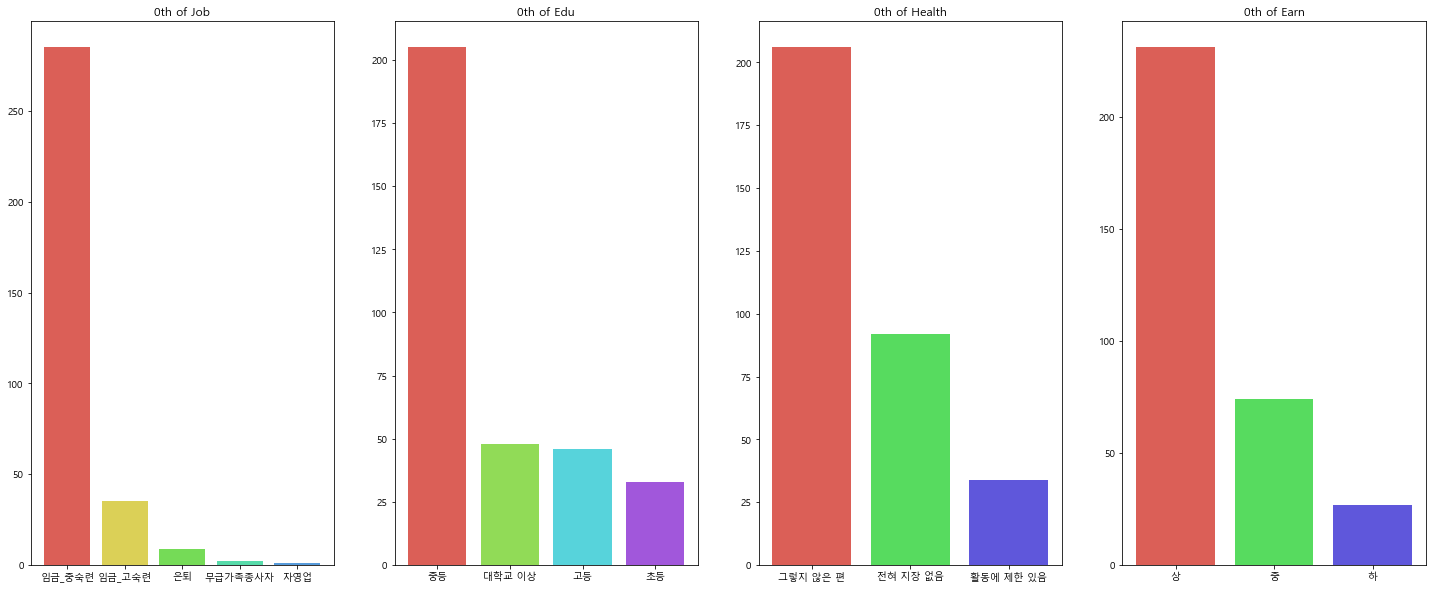

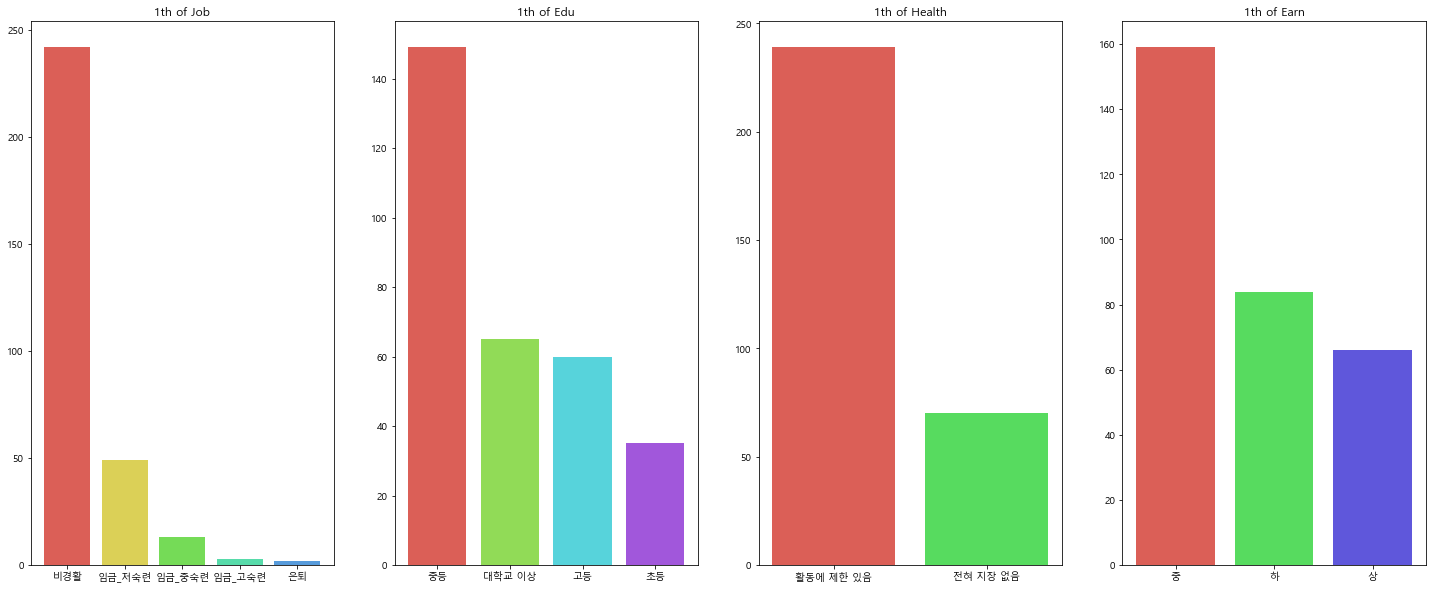

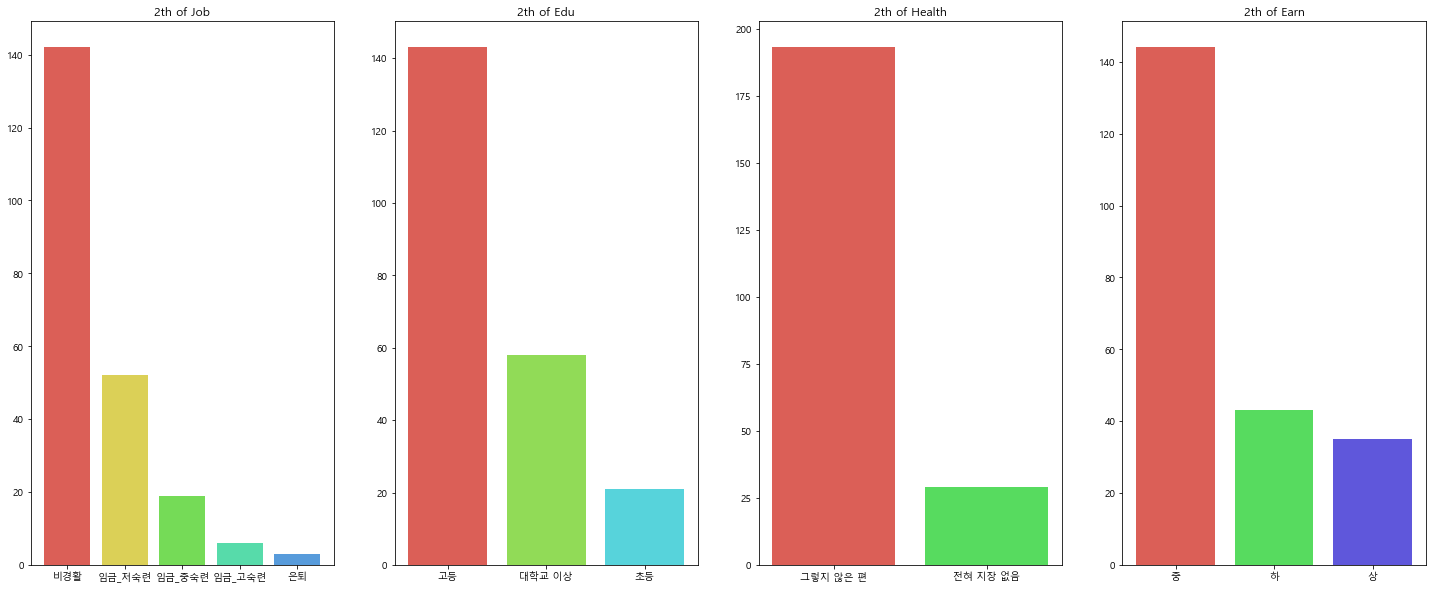

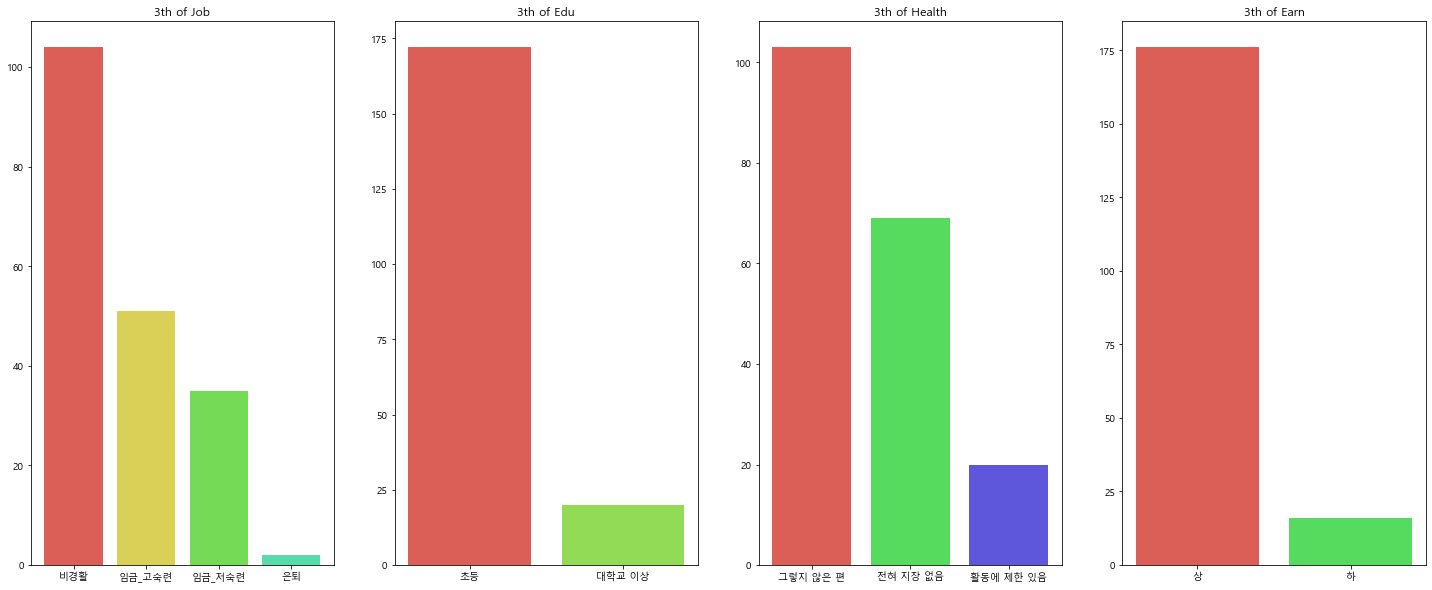

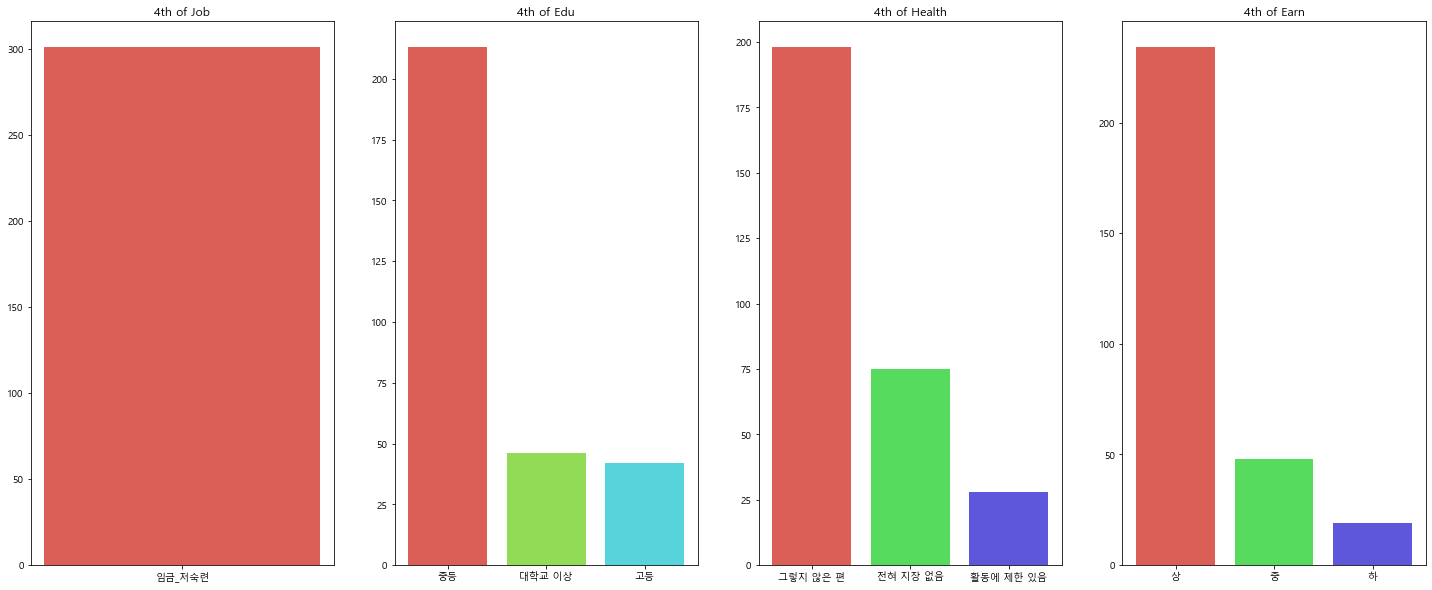

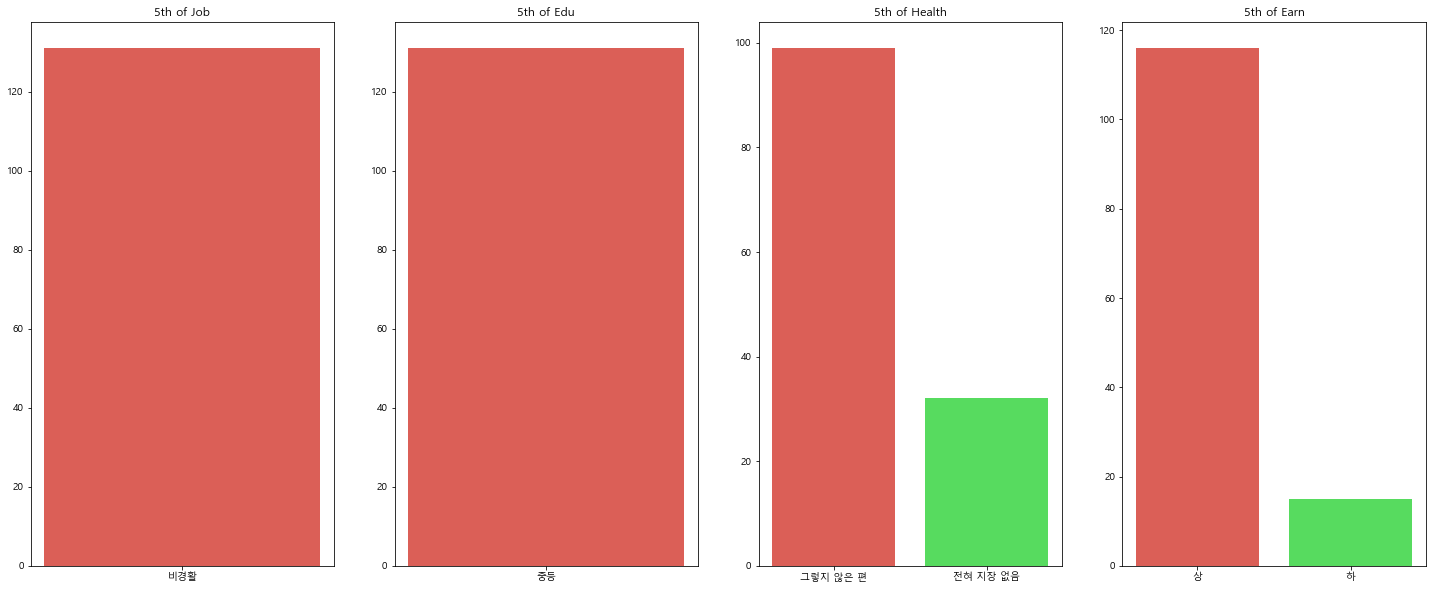

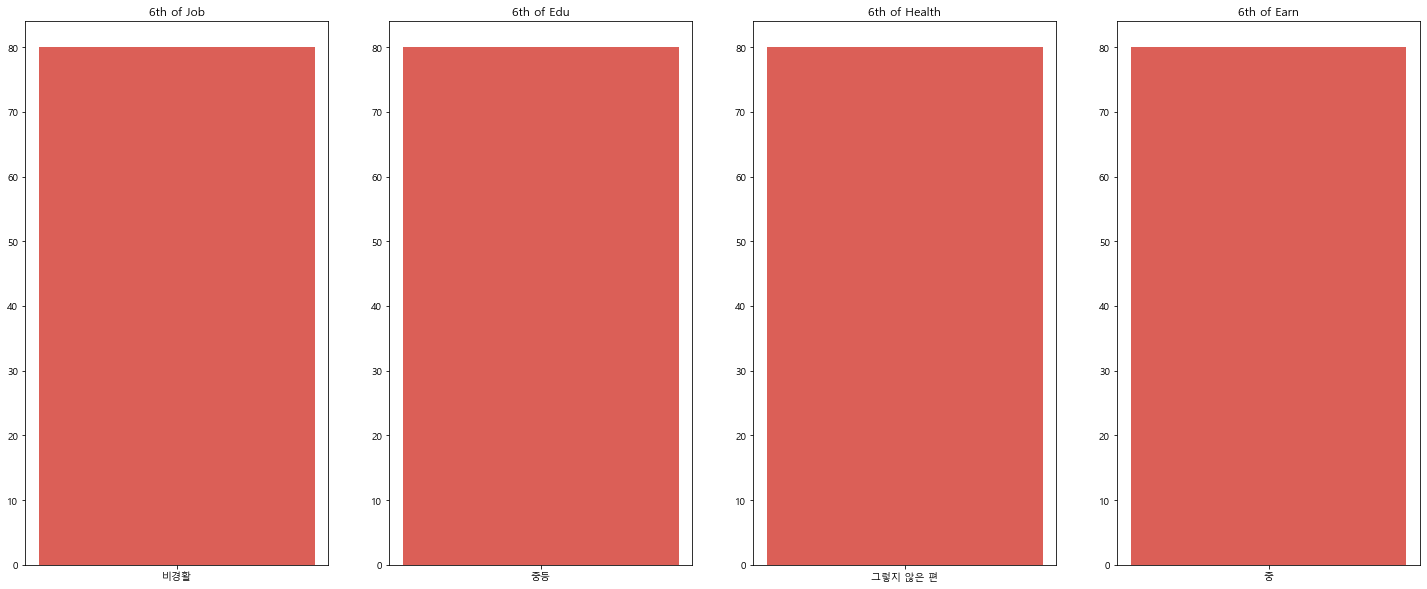

In [25]:
cols = data.drop(['Gender','Cluster'], axis=1).columns
for clus in range(0, 7):
    plt.figure(figsize=(25, 10))
    n = 1 
    for i, col in enumerate(cols):
        ax = plt.subplot(1, 4, n)
        colors = sns.color_palette('hls',len(data[col].value_counts()))
        temp = data[data['Cluster'] == clus].drop(['Cluster'], axis=1)[col].value_counts()
        ax.bar(x = temp.index, height= temp.values, color = colors, axes= ax)
        plt.title(f'{clus}th of {col}')
        n += 1
    plt.show()

In [26]:
# 신노년세대 유형별 기술통계
cols = data.drop(['Gender','Job', 'Edu', 'Cluster'], axis=1).columns
clus = data.Cluster.unique()
for clu in clus:
    temp = data[data['Cluster']==clu]
    print(f'Size of {clu}th Cluster:', np.round(len(temp)/len(data),2))
    for col in cols:
        print(f'{clu}th Cluster of {col} ratio')
        print(temp[col].value_counts(normalize=True))
    print('-----------------------------------------------------------')

Size of 2th Cluster: 0.14
2th Cluster of Health ratio
그렇지 않은 편    0.869369
전혀 지장 없음    0.130631
Name: Health, dtype: float64
2th Cluster of Earn ratio
중    0.648649
하    0.193694
상    0.157658
Name: Earn, dtype: float64
-----------------------------------------------------------
Size of 3th Cluster: 0.12
3th Cluster of Health ratio
그렇지 않은 편     0.536458
전혀 지장 없음     0.359375
활동에 제한 있음    0.104167
Name: Health, dtype: float64
3th Cluster of Earn ratio
상    0.916667
하    0.083333
Name: Earn, dtype: float64
-----------------------------------------------------------
Size of 0th Cluster: 0.21
0th Cluster of Health ratio
그렇지 않은 편     0.620482
전혀 지장 없음     0.277108
활동에 제한 있음    0.102410
Name: Health, dtype: float64
0th Cluster of Earn ratio
상    0.695783
중    0.222892
하    0.081325
Name: Earn, dtype: float64
-----------------------------------------------------------
Size of 1th Cluster: 0.2
1th Cluster of Health ratio
활동에 제한 있음    0.773463
전혀 지장 없음     0.226537
Name: Health, dtype: float64
